# Intensity Class Examples

This notebook demonstrates the **Intensity** class from iSLAT, which calculates molecular line intensities and optical depths using radiative transfer physics. It implements the curve-of-growth formalism from Banzatti et al. 2012.

The Intensity class takes a `MoleculeLineList` and computes, for a given set of physical parameters:
- **Line optical depths (tau)** -- how optically thick each transition is
- **Line intensities** -- emergent intensity per line in CGS units

> **Note:** This notebook uses CO as its primary molecule because its compact line list (~1 000 lines) keeps every cell fast and interactive.  H2O (~50 000 lines) is loaded only where its dense spectrum is essential (overlap treatment).

## Key Features Demonstrated:
1. **Creating an Intensity Instance** -- Initialize from a MoleculeLineList
2. **Basic Intensity Calculation** -- Compute intensities for a single set of parameters
3. **Accessing Results** -- Retrieve intensities, optical depths, and tabular data
4. **Calculation Methods** -- Compare curve-of-growth vs. RADEX approximations
5. **Temperature Dependence** -- See how line strengths change with temperature
6. **Column Density Effects** -- Explore optically thin vs. thick regimes
7. **Overlapping Line Treatment** -- How blended lines are handled
8. **Filtering Lines by Range** -- Extract lines in a wavelength window
9. **Caching Behaviour** -- Understand when results are reused or recalculated

For **batch / multidimensional array** calculations, see the companion notebook *Intensity_Batch_Examples*.

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

# Import data types from iSLAT
from iSLAT.Modules.DataTypes import Intensity, MoleculeLineList

print("iSLAT data types imported successfully!")

iSLAT data types imported successfully!


In [2]:
from iSLAT.Modules.FileHandling import hitran_data_folder_path

# Define paths to HITRAN parameter files
data_dir = hitran_data_folder_path

co_par_file    = str(data_dir / "data_Hitran_CO.par")
water_par_file = str(data_dir / "data_Hitran_H2O.par")  # used later for overlap demo

# Wavelength window (microns) -- all line lists will be restricted to this range
wavelength_range = (4.5, 5.2)

## 1. Creating an Intensity Instance

The `Intensity` class takes a `MoleculeLineList` as its sole constructor argument. The line list provides all the molecular data (frequencies, Einstein A coefficients, energy levels, partition function) that the intensity calculation needs.

In [3]:
# Load the CO line list (compact -- keeps every cell fast)
co_lines = MoleculeLineList(
    molecule_id="CO",
    filename=co_par_file,
    wavelength_range=wavelength_range
)

print(f"Loaded {len(co_lines)} CO lines in {wavelength_range[0]}-{wavelength_range[1]} um")
print(f"Wavelength range: {co_lines.get_wavelengths().min():.4f} - {co_lines.get_wavelengths().max():.4f} um")

# Create the Intensity object
co_intensity = Intensity(co_lines)
print(f"\nIntensity object created: {co_intensity}")

Loaded 216 CO lines in 4.5-5.2 um
Wavelength range: 4.5004 - 5.1994 um

Intensity object created: Intensity(Mol-Name=CO, t_kin=None n_mol=None dv=None, tau=None, intensity=None)


## 2. Basic Intensity Calculation

Call `calc_intensity()` with three physical parameters:
- **t_kin** -- Kinetic temperature (K)
- **n_mol** -- Column density (molecules cm^-2)
- **dv** -- Intrinsic (turbulent) line width (km/s)

This computes both the line intensities and optical depths for every line in the line list.

In [4]:
# Calculate intensities for CO at T=800 K, N=1e18 cm^-2, dv=2 km/s
co_intensity.calc_intensity(t_kin=800.0, n_mol=1e18, dv=2.0)

print(f"Calculation complete!")
print(f"  Temperature:     {co_intensity.t_kin} K")
print(f"  Column density:  {co_intensity.n_mol:.2e} cm^-2")
print(f"  Line width:      {co_intensity.dv} km/s")
print(f"  Intensity shape: {co_intensity.intensity.shape}")
print(f"  Tau shape:       {co_intensity.tau.shape}")

Calculation complete!
  Temperature:     800.0 K
  Column density:  1.00e+18 cm^-2
  Line width:      2.0 km/s
  Intensity shape: (216,)
  Tau shape:       (216,)


## 3. Accessing Results

After a calculation, the results are available through properties:
- `intensity` -- numpy array of line intensities (erg/s/cm^2/sr/Hz)
- `tau` -- numpy array of line-centre optical depths
- `get_table` -- Pandas DataFrame combining line data with intensity and tau
- `molecule` -- the underlying MoleculeLineList

In [5]:
# Numerical summary
print("Intensity statistics:")
print(f"  Min:    {co_intensity.intensity.min():.4e}")
print(f"  Max:    {co_intensity.intensity.max():.4e}")
print(f"  Median: {np.median(co_intensity.intensity):.4e}")

print(f"\nOptical depth statistics:")
print(f"  Min:    {co_intensity.tau.min():.4e}")
print(f"  Max:    {co_intensity.tau.max():.4e}")
print(f"  Median: {np.median(co_intensity.tau):.4e}")

# Count optically thin vs thick lines
n_thin = np.sum(co_intensity.tau < 1.0)
n_thick = np.sum(co_intensity.tau >= 1.0)
print(f"\nOptically thin  (tau < 1):  {n_thin}")
print(f"Optically thick (tau >= 1): {n_thick}")

Intensity statistics:
  Min:    6.2468e-02
  Max:    8.0188e+01
  Median: 9.5064e+00

Optical depth statistics:
  Min:    1.6178e-03
  Max:    1.7084e+01
  Median: 2.7024e-01

Optically thin  (tau < 1):  158
Optically thick (tau >= 1): 58


In [6]:
# Get a full table with line data + computed intensity and tau
table = co_intensity.get_table
print(f"Table columns: {list(table.columns)}")
print(f"Table shape:   {table.shape}")

# Show the 10 strongest lines by intensity
display(table.nlargest(10, 'intens'))

Table columns: ['lev_up', 'lev_low', 'lam', 'tau', 'intens', 'a_stein', 'e_up', 'e_low', 'g_up', 'g_low']
Table shape:   (216, 10)


,lev_up,lev_low,lam,tau,intens,a_stein,e_up,e_low,g_up,g_low
184,1|,0|R_11,4.57323,17.083882,80.187786,18.24,3511.05615,364.97049,25,23
188,1|,0|R_12,4.56617,17.035946,80.154739,18.38,3582.24243,431.29581,27,25
181,1|,0|R_10,4.58038,16.886562,80.058932,18.08,3445.33496,304.16333,23,21
191,1|,0|R_13,4.55922,16.778806,79.981672,18.52,3658.89062,503.13666,29,27
178,1|,0|R_9,4.58764,16.441843,79.756364,17.91,3385.08203,248.87671,21,19
194,1|,0|R_14,4.55236,16.333972,79.672185,18.66,3740.99902,580.49066,31,29
175,1|,0|R_8,4.59499,15.736190,79.244494,17.72,3330.29907,199.11290,19,17
198,1|,0|R_15,4.54560,15.717682,79.218860,18.79,3828.56396,663.35449,33,31
108,1|,0|P_12,4.77358,15.593646,78.909281,17.35,3445.33496,431.29581,23,25
111,1|,0|P_11,4.76399,15.528699,78.881736,17.52,3385.08203,364.97049,21,23


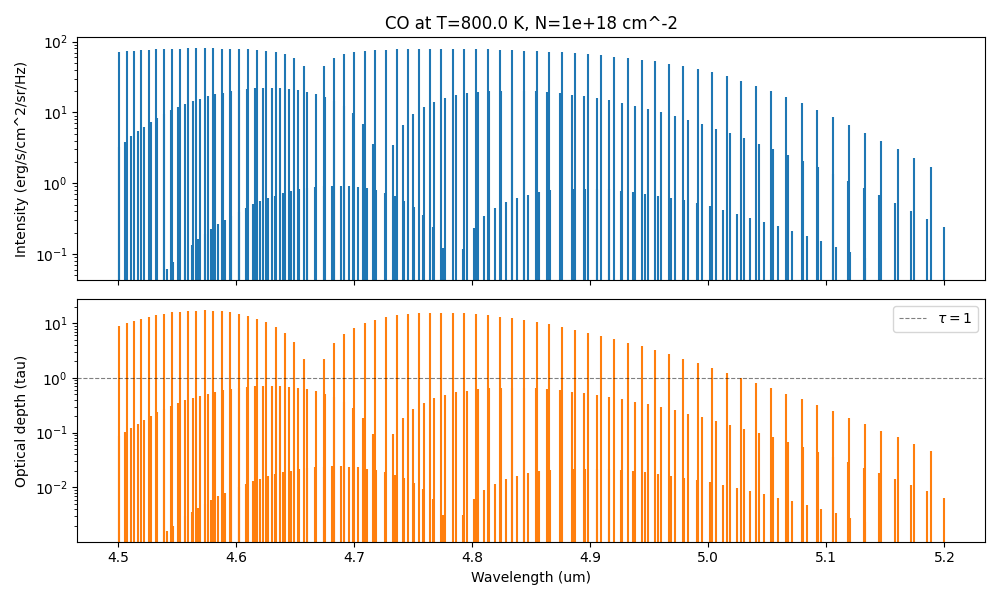

In [7]:
# Plot intensity and optical depth vs wavelength
wavelengths = co_intensity.molecule.get_wavelengths()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax1.stem(wavelengths, co_intensity.intensity, markerfmt=' ', basefmt=' ')
ax1.set_ylabel('Intensity (erg/s/cm^2/sr/Hz)')
ax1.set_title(f'CO at T={co_intensity.t_kin} K, N={co_intensity.n_mol:.0e} cm^-2')
ax1.set_yscale('log')

ax2.stem(wavelengths, co_intensity.tau, markerfmt=' ', basefmt=' ', linefmt='C1-')
ax2.axhline(1.0, color='k', ls='--', lw=0.8, alpha=0.5, label=r'$\tau = 1$')
ax2.set_xlabel('Wavelength (um)')
ax2.set_ylabel('Optical depth (tau)')
ax2.set_yscale('log')
ax2.legend()

plt.tight_layout()
plt.show()

## 4. Calculation Methods

The `method` parameter controls how optical depth is converted to intensity:

| Method | Description |
|---|---|
| `"curve_growth"` | Full curve-of-growth integral with overlap treatment (default, Eq. A1 in Banzatti+2012) |
| `"curve_growth_no_overlap"` | Curve-of-growth without blended-line correction |
| `"radex"` | Simpler `1 - exp(-tau)` approximation (as in RADEX; van der Tak+2007) |

All three agree in the optically thin limit; they diverge for tau >> 1.

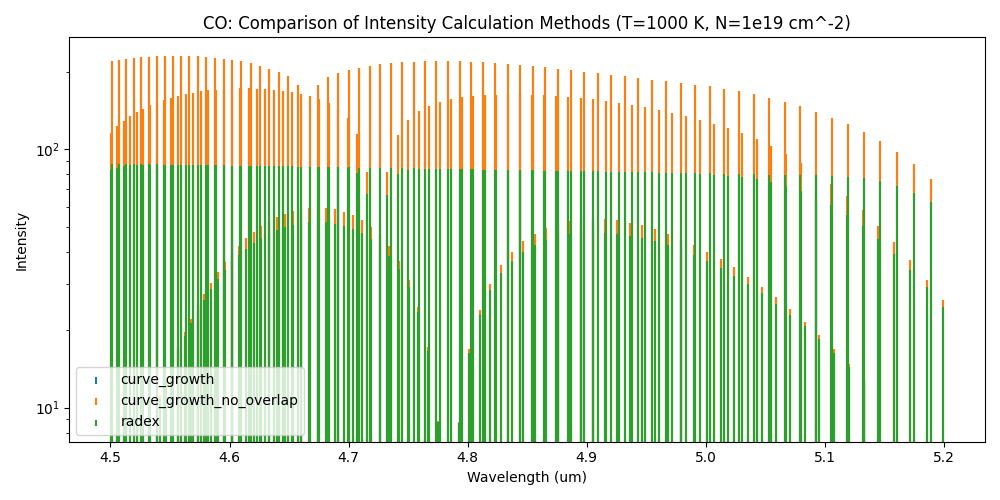

In [8]:
# Compare the three methods (reusing the CO line list loaded above)
methods = ["curve_growth", "curve_growth_no_overlap", "radex"]
results = {}

for method in methods:
    intens = Intensity(co_lines)
    intens.calc_intensity(t_kin=1000.0, n_mol=1e19, dv=2.0, method=method)
    results[method] = intens.intensity.copy()

co_wl = co_lines.get_wavelengths()

fig, ax = plt.subplots(figsize=(10, 5))

ax.stem(co_wl, results["curve_growth"], markerfmt=' ', basefmt=' ',
        linefmt='C0-', label='curve_growth')
ax.stem(co_wl, results["curve_growth_no_overlap"], markerfmt=' ', basefmt=' ',
        linefmt='C1-', label='curve_growth_no_overlap')
ax.stem(co_wl, results["radex"], markerfmt=' ', basefmt=' ',
        linefmt='C2-', label='radex')

ax.set_xlabel('Wavelength (um)')
ax.set_ylabel('Intensity')
ax.set_title('CO: Comparison of Intensity Calculation Methods (T=1000 K, N=1e19 cm^-2)')
ax.set_yscale('log')
ax.legend()

plt.tight_layout()
plt.show()

In [9]:
# Quantify the differences
print("Method comparison (CO at T=1000 K, N=1e19):")
print(f"{'Method':<30s} {'Sum(I)':<14s} {'Max(I)':<14s}")
print("-" * 58)
for method, intens_arr in results.items():
    print(f"{method:<30s} {intens_arr.sum():<14.4e} {intens_arr.max():<14.4e}")

# Ratio of curve_growth to radex (shows where they diverge)
ratio = results["curve_growth"] / np.clip(results["radex"], 1e-300, None)
print(f"\ncurve_growth / radex ratio:")
print(f"  Min:  {ratio.min():.4f}")
print(f"  Max:  {ratio.max():.4f}")
print(f"  Mean: {ratio.mean():.4f}")

Method comparison (CO at T=1000 K, N=1e19):
Method                         Sum(I)         Max(I)        
----------------------------------------------------------
curve_growth                   2.6501e+04     2.3038e+02    
curve_growth_no_overlap        2.6501e+04     2.3038e+02    
radex                          1.4189e+04     8.7886e+01    

curve_growth / radex ratio:
  Min:  1.0162
  Max:  2.6445
  Mean: 1.6941


## 5. Temperature Dependence

Temperature affects line intensities through:
- The **Boltzmann population** of upper and lower energy levels
- The **partition function** Q(T)
- The **Planck (blackbody)** source function

Higher temperatures excite higher-energy transitions while depopulating the ground-state lines.

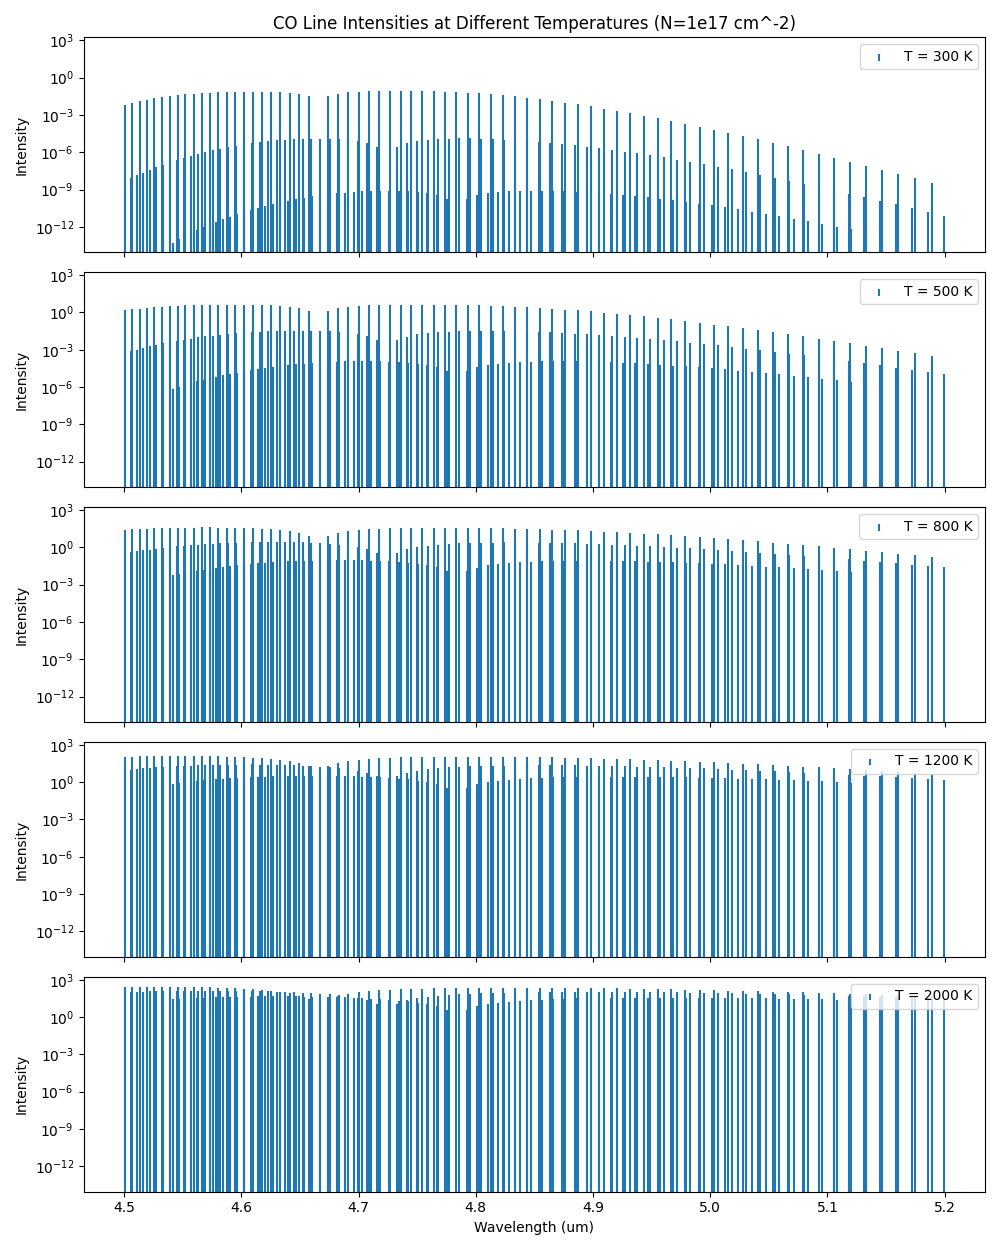

In [10]:
# Show how CO line intensities change with temperature
temperatures = [300, 500, 800, 1200, 2000]
colors = plt.cm.hot(np.linspace(0.2, 0.9, len(temperatures)))

fig, axes = plt.subplots(len(temperatures), 1, figsize=(10, 2.5 * len(temperatures)),
                         sharex=True, sharey=True)

for ax, temp, color in zip(axes, temperatures, colors):
    intens = Intensity(co_lines)
    intens.calc_intensity(t_kin=temp, n_mol=1e17, dv=2.0)
    ax.stem(wavelengths, intens.intensity, markerfmt=' ', basefmt=' ',
            linefmt='-', label=f'T = {temp} K')
    ax.set_ylabel('Intensity')
    ax.set_yscale('log')
    ax.legend(loc='upper right')

axes[-1].set_xlabel('Wavelength (um)')
axes[0].set_title('CO Line Intensities at Different Temperatures (N=1e17 cm^-2)')

plt.tight_layout()
plt.show()

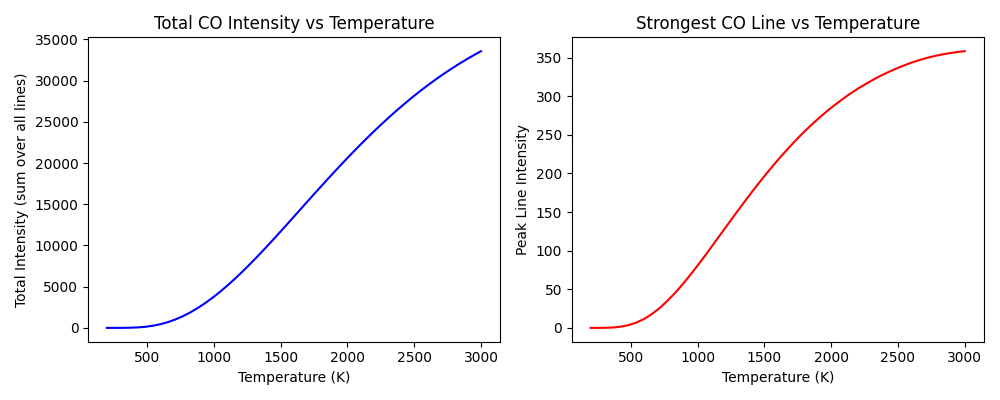

In [11]:
# Track the total intensity and strongest-line intensity vs temperature
temp_grid = np.linspace(200, 3000, 50)
total_intens = []
max_intens = []

intens_obj = Intensity(co_lines)
for temp in temp_grid:
    intens_obj.calc_intensity(t_kin=temp, n_mol=1e17, dv=2.0)
    total_intens.append(intens_obj.intensity.sum())
    max_intens.append(intens_obj.intensity.max())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(temp_grid, total_intens, 'b-')
ax1.set_xlabel('Temperature (K)')
ax1.set_ylabel('Total Intensity (sum over all lines)')
ax1.set_title('Total CO Intensity vs Temperature')

ax2.plot(temp_grid, max_intens, 'r-')
ax2.set_xlabel('Temperature (K)')
ax2.set_ylabel('Peak Line Intensity')
ax2.set_title('Strongest CO Line vs Temperature')

plt.tight_layout()
plt.show()

## 6. Column Density Effects

Column density controls how optically thick the gas is:
- **Low N** — optically thin: intensity grows linearly with N, all lines proportional to each other
- **High N** — optically thick: strong lines saturate while weak lines keep growing, changing the line ratios

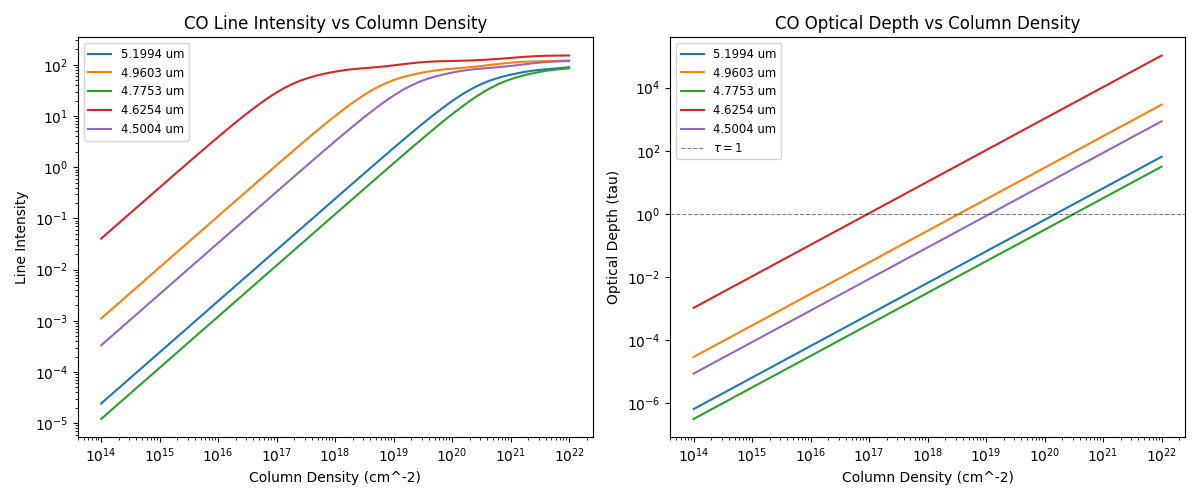

In [12]:
# Show intensity vs column density for individual CO lines
co_intens = Intensity(co_lines)

n_mol_grid = np.logspace(14, 22, 60)
co_wl = co_lines.get_wavelengths()

# Pick a few representative lines spread across the loaded range
sample_indices = np.linspace(0, len(co_wl) - 1, min(5, len(co_wl)), dtype=int)
sample_labels = [f'{co_wl[i]:.4f} um' for i in sample_indices]

intens_vs_n = np.zeros((len(n_mol_grid), len(sample_indices)))
tau_vs_n = np.zeros_like(intens_vs_n)

for j, n_mol in enumerate(n_mol_grid):
    co_intens.calc_intensity(t_kin=800.0, n_mol=n_mol, dv=2.0)
    intens_vs_n[j, :] = co_intens.intensity[sample_indices]
    tau_vs_n[j, :] = co_intens.tau[sample_indices]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

for k, label in enumerate(sample_labels):
    ax1.plot(n_mol_grid, intens_vs_n[:, k], label=label)
    ax2.plot(n_mol_grid, tau_vs_n[:, k], label=label)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Column Density (cm^-2)')
ax1.set_ylabel('Line Intensity')
ax1.set_title('CO Line Intensity vs Column Density')
ax1.legend(fontsize='small')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.axhline(1.0, color='k', ls='--', lw=0.8, alpha=0.5, label=r'$\tau=1$')
ax2.set_xlabel('Column Density (cm^-2)')
ax2.set_ylabel('Optical Depth (tau)')
ax2.set_title('CO Optical Depth vs Column Density')
ax2.legend(fontsize='small')

plt.tight_layout()
plt.show()

## 7. Overlapping Line Treatment

When two spectral lines are close in frequency (within the broadening width), their optical depths overlap. The `curve_growth` method correctly sums the optical depths before computing the curve-of-growth integral, then distributes the resulting intensity proportionally.

This avoids unphysical intensity enhancement that would occur if overlapping lines were treated independently.

We load **H2O** here because its dense line spectrum produces many blends -- CO lines are too widely spaced to overlap at typical broadening widths.

In [13]:
# Load H2O for the overlap demo (its dense spectrum produces many blends)
h2o_lines = MoleculeLineList(molecule_id="H2O", filename=water_par_file,
                             wavelength_range=wavelength_range)
h2o_wavelengths = h2o_lines.get_wavelengths()
print(f"Loaded {len(h2o_lines)} H2O lines in {wavelength_range[0]}-{wavelength_range[1]} um for overlap comparison")

# Compare with and without overlap treatment at high column density
# (overlap matters most when lines are optically thick)
intens_overlap = Intensity(h2o_lines)
intens_no_overlap = Intensity(h2o_lines)

intens_overlap.calc_intensity(t_kin=800.0, n_mol=1e20, dv=3.0, method="curve_growth")
intens_no_overlap.calc_intensity(t_kin=800.0, n_mol=1e20, dv=3.0, method="curve_growth_no_overlap")

ratio = intens_overlap.intensity / np.clip(intens_no_overlap.intensity, 1e-300, None)

# Find lines most affected by overlap treatment
diff_mask = np.abs(ratio - 1.0) > 0.01  # more than 1% different
print(f"Lines affected by overlap treatment: {diff_mask.sum()} / {len(ratio)}")
print(f"Max ratio (overlap / no-overlap):  {ratio.max():.4f}")
print(f"Min ratio (overlap / no-overlap):  {ratio[ratio > 0].min():.4f}")

Loaded 2625 H2O lines in 4.5-5.2 um for overlap comparison
Lines affected by overlap treatment: 470 / 2625
Max ratio (overlap / no-overlap):  1.0000
Min ratio (overlap / no-overlap):  0.0445


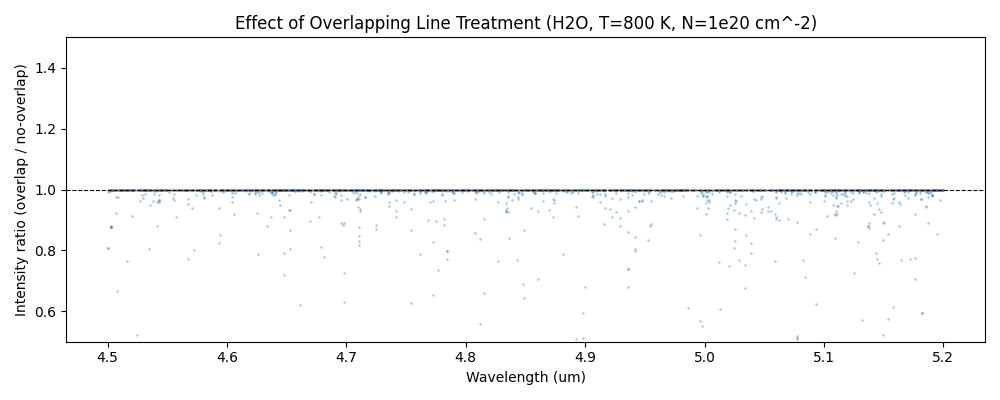

In [14]:
# Plot the ratio to visualize where overlap matters
fig, ax = plt.subplots(figsize=(10, 4))

ax.scatter(h2o_wavelengths, ratio, s=1, alpha=0.3, c='steelblue')
ax.axhline(1.0, color='k', ls='--', lw=0.8)
ax.set_xlabel('Wavelength (um)')
ax.set_ylabel('Intensity ratio (overlap / no-overlap)')
ax.set_title('Effect of Overlapping Line Treatment (H2O, T=800 K, N=1e20 cm^-2)')
ax.set_ylim(0.5, 1.5)

plt.tight_layout()
plt.show()

## 8. Filtering Lines by Wavelength Range

Use `get_table_in_range()` to retrieve a DataFrame of lines within a specific wavelength window, or `get_lines_in_range_with_intensity()` to get `MoleculeLine` objects paired with their computed intensity and tau values.

In [15]:
# Recalculate at moderate conditions
co_intensity.calc_intensity(t_kin=800.0, n_mol=1e18, dv=2.0)

# Pick a narrow sub-window inside the loaded wavelength range
sub_lo = wavelength_range[0] + 0.1
sub_hi = sub_lo + 0.2

sub_table = co_intensity.get_table_in_range(sub_lo, sub_hi)
print(f"Lines between {sub_lo:.1f}-{sub_hi:.1f} um: {len(sub_table)}")
display(sub_table.head(10))

Lines between 4.6-4.8 um: 72


,lev_up,lev_low,lam,tau,intens,a_stein,e_up,e_low,g_up,g_low
101,2|,1|P_8,4.79537,0.588957,18.632381,34.94,6281.33105,3280.98853,15,17
102,1|,0|P_14,4.79312,15.089298,78.465101,17.03,3582.24243,580.49066,27,29
103,3|,2|P_1,4.79248,0.003113,0.119730,98.27,9136.86523,6134.71045,1,3
104,2|,1|P_7,4.78608,0.544429,17.474154,35.48,6243.32275,3237.15210,13,15
105,1|,0|P_13,4.78330,15.442069,78.769117,17.19,3511.05591,503.13666,25,27
106,2|,1|P_6,4.77689,0.489680,15.999575,36.15,6210.74268,3198.79150,11,13
107,3|,2|R_0,4.77528,0.003136,0.120679,33.12,9142.24512,6129.27832,3,1
108,1|,0|P_12,4.77358,15.593646,78.909281,17.35,3445.33496,431.29581,23,25
109,2|,1|P_5,4.76782,0.425376,14.194836,37.04,6183.58984,3165.90845,9,11
110,3|,2|R_1,4.76685,0.006231,0.239590,39.96,9153.00781,6134.71045,5,3


In [16]:
# get_lines_in_range_with_intensity returns (MoleculeLine, intensity, tau) tuples
lines_with_intens = co_intensity.get_lines_in_range_with_intensity(sub_lo, sub_hi)

print(f"Lines in {sub_lo:.1f}-{sub_hi:.1f} um: {len(lines_with_intens)}")
print(f"\n{'Wavelength':>12s}  {'E_up':>10s}  {'Intensity':>12s}  {'Tau':>10s}  Transition")
print("-" * 75)
for line, intens_val, tau_val in lines_with_intens[:10]:
    print(f"{line.lam:12.5f}  {line.e_up:10.2f}  {intens_val:12.4e}  {tau_val:10.4e}  "
          f"{line.lev_up} -> {line.lev_low}")

Lines in 4.6-4.8 um: 72

  Wavelength        E_up     Intensity         Tau  Transition
---------------------------------------------------------------------------
     4.79537     6281.33    1.8632e+01  5.8896e-01  2| -> 1|P_8
     4.79312     3582.24    7.8465e+01  1.5089e+01  1| -> 0|P_14
     4.79248     9136.87    1.1973e-01  3.1127e-03  3| -> 2|P_1
     4.78608     6243.32    1.7474e+01  5.4443e-01  2| -> 1|P_7
     4.78330     3511.06    7.8769e+01  1.5442e+01  1| -> 0|P_13
     4.77689     6210.74    1.6000e+01  4.8968e-01  2| -> 1|P_6
     4.77528     9142.25    1.2068e-01  3.1357e-03  3| -> 2|R_0
     4.77358     3445.33    7.8909e+01  1.5594e+01  1| -> 0|P_12
     4.76782     6183.59    1.4195e+01  4.2538e-01  2| -> 1|P_5
     4.76685     9153.01    2.3959e-01  6.2306e-03  3| -> 2|R_1


## 9. Caching Behaviour

The Intensity class caches calculation results. Calling `calc_intensity()` with the **same** parameters is a no-op (cache hit). Changing any parameter triggers a recalculation. Use `invalidate_cache()` to force recalculation.

In [17]:
import time

test_intens = Intensity(co_lines)

# First call: full calculation
t0 = time.perf_counter()
test_intens.calc_intensity(t_kin=500.0, n_mol=1e18, dv=2.0)
t_first = time.perf_counter() - t0
print(f"First call (full calculation): {t_first*1000:.2f} ms")

# Second call with same params: cache hit
t0 = time.perf_counter()
test_intens.calc_intensity(t_kin=500.0, n_mol=1e18, dv=2.0)
t_cached = time.perf_counter() - t0
print(f"Same params (cache hit):       {t_cached*1000:.4f} ms")

# Different param: recalculation
t0 = time.perf_counter()
test_intens.calc_intensity(t_kin=700.0, n_mol=1e18, dv=2.0)
t_recalc = time.perf_counter() - t0
print(f"Changed T (recalculation):     {t_recalc*1000:.2f} ms")

# Force invalidation
test_intens.invalidate_cache()
t0 = time.perf_counter()
test_intens.calc_intensity(t_kin=700.0, n_mol=1e18, dv=2.0)
t_forced = time.perf_counter() - t0
print(f"After invalidate_cache():      {t_forced*1000:.2f} ms")

First call (full calculation): 1.65 ms
Same params (cache hit):       0.1464 ms
Changed T (recalculation):     1.18 ms
After invalidate_cache():      0.93 ms
